# Portfolio Optimization
In this notebook, we will first solve the problem discussed in [this lecture note](https://www2.isye.gatech.edu/~sahmed/isye6669/notes/portfolio). Then using the same data, we will solve three different optimization problems commonly encountered in Portfolio optimization.

1. Exact problem discussed in the lecture note
2. Maximizing mean return
3. Minimizing risk
4. Simultaneously maximizing mean and minimizing risk

We will use [Convex.jl](https://github.com/jump-dev/Convex.jl) library to solve constrained quadratic optimization problems.

Import relevant libraries. If any library is not installed, first install it before importing.

In [1]:
using Convex, SCS
using LinearAlgebra
using Statistics
using Plots

## 1. Problem discussed in the lecture note
The dataset used in this notebook can be found in the lecture notes of [Prof. Shabbir Ahmed](https://www2.isye.gatech.edu/people/faculty/Shabbir_Ahmed/). The lecture note can be found at [this link](https://www2.isye.gatech.edu/~sahmed/isye6669/notes/portfolio).

Read the data.

In [2]:
IBM = [93.043, 84.585, 111.453, 99.525, 95.819, 114.708, 111.515, 113.211, 104.942, 99.827, 91.607, 107.937, 115.590];
WMT = [51.826, 52.823, 56.477, 49.805, 50.287, 51.521, 51.531, 48.664, 55.744, 47.916, 49.438, 51.336, 55.081];
SEHI =[1.063, 0.938, 1.000, 0.938, 1.438, 1.700, 2.540, 2.390, 3.120, 2.980, 1.900, 1.750, 1.800];
data = [IBM WMT SEHI]

13×3 Array{Float64,2}:
  93.043  51.826  1.063
  84.585  52.823  0.938
 111.453  56.477  1.0
  99.525  49.805  0.938
  95.819  50.287  1.438
 114.708  51.521  1.7
 111.515  51.531  2.54
 113.211  48.664  2.39
 104.942  55.744  3.12
  99.827  47.916  2.98
  91.607  49.438  1.9
 107.937  51.336  1.75
 115.59   55.081  1.8

In [3]:
size(data)

(13, 3)

### Calculate change in stock price
Change in stock price is calculated by subtracting a given day's stock price from following day's stock price.

In [4]:
change_in_stock_price = data[2:end, :] - data[1:(end - 1), :]

12×3 Array{Float64,2}:
  -8.458   0.997  -0.125
  26.868   3.654   0.062
 -11.928  -6.672  -0.062
  -3.706   0.482   0.5
  18.889   1.234   0.262
  -3.193   0.01    0.84
   1.696  -2.867  -0.15
  -8.269   7.08    0.73
  -5.115  -7.828  -0.14
  -8.22    1.522  -1.08
  16.33    1.898  -0.15
   7.653   3.745   0.05

### Calculate rate of change of stock price

In [5]:
rate_of_return = change_in_stock_price ./ data[1:(end-1), :]

12×3 Array{Float64,2}:
 -0.0909042   0.0192374    -0.117592
  0.317645    0.0691744     0.0660981
 -0.107023   -0.118137     -0.062
 -0.0372369   0.00967774    0.533049
  0.197132    0.0245391     0.182197
 -0.0278359   0.000194096   0.494118
  0.0152087  -0.0556364    -0.0590551
 -0.0730406   0.145487      0.305439
 -0.0487412  -0.140428     -0.0448718
 -0.0823425   0.0317639    -0.362416
  0.178261    0.0383915    -0.0789474
  0.0709025   0.0729508     0.0285714

### Sample covariance matrix

In [6]:
C = Statistics.cov(rate_of_return)

3×3 Array{Float64,2}:
 0.018641    0.00359853  0.00130976
 0.00359853  0.00643694  0.00488727
 0.00130976  0.00488727  0.0686828

Covariance matrix given in the paper is slightly different from this result.

### Mean return for each stock

In [7]:
means = mean(rate_of_return, dims = 1)

1×3 Array{Float64,2}:
 0.0260022  0.00810132  0.0737159

### Optimization problem of the book

Notation:
C: Covariance matrix


Problem: 

$$\min x^TCx$$

s.t.

$$e^Tx \leq 1000$$
$$\bar{r}^Tx \geq 50$$
$$ x \geq 0$$

The solver solves problems of the following kind:

$$ \min x^TCx + q^T x$$
s.t.

$$Gx \leq h$$
$$Ax = b$$

So we convert our constraints to a form understandable by the solver. We don't have any equality constraints. We modify all inequality constraints to less than equal to type. The matrix $G$ takes following form.

$$\begin{pmatrix}
1 & 1 & 1\\
-0.026 & -0.008 & -0.073\\
-1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & -1\\
\end{pmatrix} \begin{pmatrix} x_1 \\ 
x_2 \\
x_3 \end{pmatrix}\leq 
\begin{pmatrix}
1000\\ 
-50 \\ 
0\\ 
0 \\ 
0 \end{pmatrix}$$

In [8]:
G = [ones(1,3); -means ; -Matrix(I, 3, 3)]

5×3 Array{Float64,2}:
  1.0         1.0          1.0
 -0.0260022  -0.00810132  -0.0737159
 -1.0         0.0          0.0
  0.0        -1.0          0.0
  0.0         0.0         -1.0

In [9]:
h = [1000; -50; 0; 0; 0]

5-element Array{Int64,1}:
 1000
  -50
    0
    0
    0

In [10]:
n = 3;
x = Variable(n);
problem_1 = minimize(quadform(x, C), [G*x <= h])
solve!(problem_1, () -> SCS.Optimizer(verbose = false))
print("Variance is: ", problem_1.optval)
print("\nSolution (x) is: ", x.value)

Variance is: 22634.411968303655
Solution (x) is: [497.0454857672905; 3.959747439986649e-5; 502.9543776456514]

Obtained variance is higher than that of the paper. This is because the covariance matrix given in the paper is slightly different that sample covariance matrix.

## 2. Maximizing mean return

$m$ : mean 

$ e= [1, 1, 1]^T$

Problem:
$$\max x^Tm$$
s.t.
$$e^Tx = 1$$
$$x^TCx \leq \sigma_0^2$$
$$ x \geq 0$$

We have taken $\sigma_0^2 = 130$.

In [11]:
e = ones(3,1);
x_2 = Variable(n);
problem_2 = maximize(x_2'* means',                 # Mean vector is a row vector
                     [e'*x_2 == 1, quadform(x_2, C) <= 130, -Matrix(I, 3, 3)*x_2 <= zeros(3,1)])
solve!(problem_2, () -> SCS.Optimizer(verbose = false))
print("Mean return is: ", problem_2.optval)
print("\nSolution (x) is: ", x_2.value)

Mean return is: 0.07371591290943874
Solution (x) is: [5.103025927845735e-9; -3.484487961592897e-9; 1.0000000023983249]

## 3. Minimizing risk
$e = [1, 1, 1]^T$

$m$ = mean 

Problem:
$$ \min x^TCx$$
s.t.
$$e^Tx = 1$$
$$x^Tm = m_0$$
$$ x \geq 0 $$

We have taken $m_0 = 0.05$. We have taken this peculiar value because solution doesn't exist for all values of $m_0$. For $m_0 = 1, 5, 10, 50, etc. $ no solution exists.

In [12]:
m_0 = 0.05;
x_3 = Variable(n);
problem_3 = minimize(quadform(x_3, C),
                     [e'*x_3 == 1, means*x_3 == m_0, -Matrix(I, 3, 3)*x_3 <= zeros(3,1)])
solve!(problem_3, () -> SCS.Optimizer(verbose = false))
print("Mean return is: ", problem_3.optval)
print("\nSolution (x) is: ", x_3.value)

Mean return is: 0.022634398881303284
Solution (x) is: [0.497045572371176; -8.615246810047704e-8; 0.5029545199368787]

## 4. Simultaneously maximizing mean return and minimizing risk
We have taken $\lambda = 5$. $\lambda$ value can  be changed to control risk and obtain different results.

$e = [1, 1, 1]^T$


Problem:
$$\max x^Tm - \lambda x^TCx$$
s.t.
$$e^Tx = 1$$
$$ x \geq 0$$

In [13]:
lamda = 5;
x_4 = Variable(n);
problem_4 = maximize(x_4'*means' - lamda * quadform(x_4, C),
                     [e'*x_4 == 1, -Matrix(I, 3, 3)*x_4 <= zeros(3,1)])
solve!(problem_4, () -> SCS.Optimizer(verbose = false))
print("Mean return is: ", problem_4.optval)
print("\nSolution (x) is: ", x_4.value)

Mean return is: -0.01281611748591159
Solution (x) is: [0.264105053084261; 0.6087802385086455; 0.12711470840222933]

### Solving for different values of $\lambda$ 

In [14]:
values = fill(NaN, 50);
x_values = fill(NaN, 50, 3);
lambda = 10 .^ range(-3, stop = 3, length = 50);
i = 1;
for lam = lambda
    x_new = Variable(n);
    problem_new = maximize(x_new' * means' - lam * quadform(x_new, C),
                           [e' * x_new == 1, -Matrix(I, 3, 3) * x_new <= zeros(3,1)]);
    solve!(problem_new, () -> SCS.Optimizer(verbose = false));
    values[i] = problem_new.optval;
    x_values[i,:] = x_new.value;
    i = i + 1
end

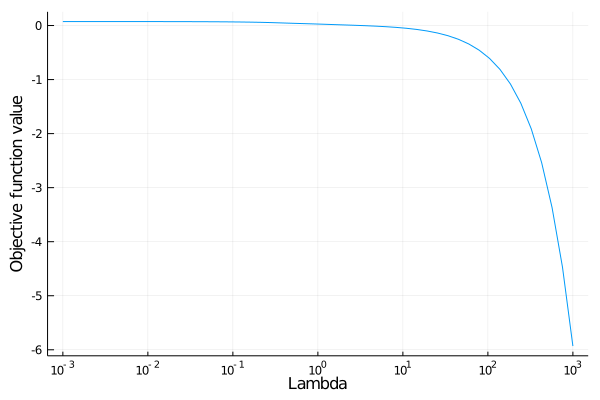

In [15]:
# Plot the result
plot(lambda, values, xaxis = :log, labels = "")
xlabel!("Lambda")
ylabel!("Objective function value")

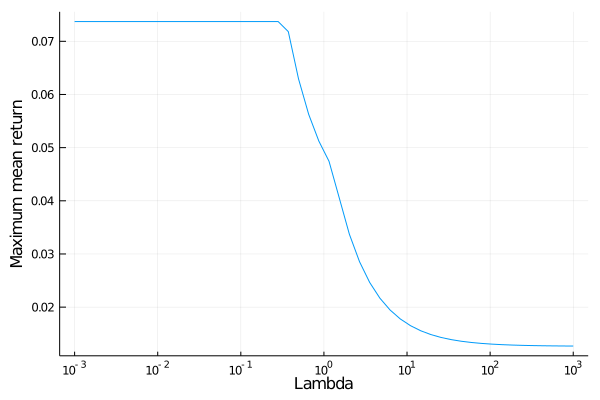

In [16]:
mean_returns = x_values * means';
plot(lambda, mean_returns, xaxis = :log, labels = "")
xlabel!("Lambda")
ylabel!("Maximum mean return")

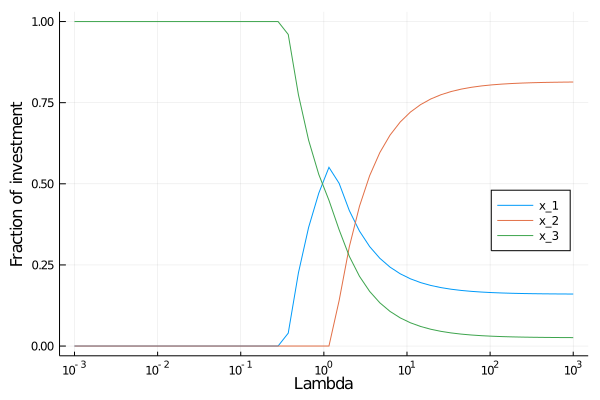

In [17]:
plot(lambda, x_values[:,1], xaxis = :log, label = "x_1", legend = :right)
plot!(lambda, x_values[:,2], xaxis = :log, label = "x_2", legend = :right)
plot!(lambda, x_values[:,3], xaxis = :log, label = "x_3", legend = :right)
xlabel!("Lambda")
ylabel!("Fraction of investment")